<a href="https://colab.research.google.com/github/KonstantinBurkin/World_vaccination_data_analysis/blob/main/Copy_of_Data_analysis_Project_15_12_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Проект "World vaccination data analysis" для МФК Основы программирования и анализа данных на Python**###

Данные из:
https://www.kaggle.com/gpreda/covid-world-vaccination-progress
https://github.com/owid/covid-19-data

## Импорт необходимых библиотек

In [ ]:
# импортирую все библиотеки, которые буду использовать
from google.colab import output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
from datetime import timedelta, date, datetime

## Скачиваю Датасет

In [ ]:
# скачиваю файл с данными о вакцинациях в разных странах с github
!wget -O "vaccinations.csv" "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"
output.clear()

## Анализ таблицы с помощью pandas

In [ ]:
# сохраняю данные во внутренних переменных с помощью pandas
data_table = pd.read_csv("vaccinations.csv")

In [ ]:
# вывожу пример первых колонок с названиями столбцов
data_table.head(1)

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# удаляю столбцы с неинтересующими меня данными, Переименовываю 'location' в 'country'.
data_table.drop(labels=['daily_vaccinations_raw', 'daily_vaccinations', 'iso_code', 'daily_people_vaccinated', 'daily_people_vaccinated_per_hundred', 'daily_vaccinations_per_million', 'total_boosters', 'total_boosters_per_hundred'], axis='columns', inplace=True)
data_table.rename(columns={'location': 'country'}, inplace=True)

In [ ]:
# обрабатываю названия колонок
def column_name_preprocess(col_name):
    for char in ['total_', 'people_']:
        col_name = col_name.replace(char, '')
        col_name = col_name.replace('_per_hundred', '_ratio')
    return col_name

column_names = data_table.columns
data_table.columns = [column_name_preprocess(col_name).title() for col_name in column_names]
# print(data_table.columns)

In [ ]:
# вывожу пример первых колонок с названиями столбцов
data_table.head(10)

,Country,Date,Vaccinations,Vaccinated,Fully_Vaccinated,Vaccinations_Ratio,Vaccinated_Ratio,Fully_Vaccinated_Ratio
0,Afghanistan,2021-02-22,0.0,0.0,NaN,0.00,0.00,NaN
1,Afghanistan,2021-02-23,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,2021-02-24,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,2021-02-25,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,2021-02-26,NaN,NaN,NaN,NaN,NaN,NaN
5,Afghanistan,2021-02-27,NaN,NaN,NaN,NaN,NaN,NaN
6,Afghanistan,2021-02-28,8200.0,8200.0,NaN,0.02,0.02,NaN
7,Afghanistan,2021-03-01,NaN,NaN,NaN,NaN,NaN,NaN
8,Afghanistan,2021-03-02,NaN,NaN,NaN,NaN,NaN,NaN
9,Afghanistan,2021-03-03,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77055 entries, 0 to 77054
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 77055 non-null  object 
 1   Date                    77055 non-null  object 
 2   Vaccinations            42630 non-null  float64
 3   Vaccinated              40689 non-null  float64
 4   Fully_Vaccinated        37767 non-null  float64
 5   Vaccinations_Ratio      42630 non-null  float64
 6   Vaccinated_Ratio        40689 non-null  float64
 7   Fully_Vaccinated_Ratio  37767 non-null  float64
dtypes: float64(6), object(2)
memory usage: 4.7+ MB


Подробная расшифровка обозначений
* Country - this is the country for which the vaccination information is 
provided;	**Категориальный, номинальный**
* Date - date for the data entry; **Категориальный, порядковый**
* Vaccinations - this is the absolute number of total immunizations in the country; **Числовой, непрерывный**
* Vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people; **Числовой, непрерывный**
* Fully_Vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); **Числовой, непрерывный**
* Vaccinations, % -  ratio between vaccination number and total population up to the date in the country; **Числовой, непрерывный**
* Vaccinated, % - ratio between population immunized and total population up to the date in the country; **Числовой, непрерывный**
* Fully_Vaccinated, % - ratio between population fully immunized and total population up to the date in the country; **Числовой, непрерывный**

In [ ]:
data_table.describe(percentiles=[.25, .75, .90])

,Vaccinations,Vaccinated,Fully_Vaccinated,Vaccinations_Ratio,Vaccinated_Ratio,Fully_Vaccinated_Ratio
count,7.702400e+04,7.624600e+04,6.646000e+04,77024.000000,76246.000000,66460.000000
mean,8.157752e+07,4.455566e+07,3.554191e+07,57.568113,31.914828,27.846082
std,5.022749e+08,2.673192e+08,2.175850e+08,57.924293,28.286249,26.560425
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000
25%,1.202908e+05,8.176100e+04,6.400200e+04,5.555000,4.320000,3.130699
50%,1.125066e+06,7.588487e+05,6.395053e+05,36.725000,25.284286,19.350000
75%,9.072456e+06,5.126391e+06,4.438239e+06,102.780714,57.923750,50.900714
90%,5.827816e+07,3.527097e+07,2.901506e+07,143.490000,73.080000,67.690000
max,9.886535e+09,4.767224e+09,4.096096e+09,327.790000,122.690000,120.700000


Vaccinations, %  | 	Vaccinated, %  | 	Fully_Vaccinated, %: 
> больше 100% - т.к. несколько доз вакцин

> Gibraltar - явно выбивается, у него много значений значительно больше 100 %




## Анализ на пропуски, заполнение пропусков

In [ ]:
# анализ столбцов на пропуски
data_table.isna().any()

Country                   False
Date                      False
Vaccinations               True
Vaccinated                 True
Fully_Vaccinated           True
Vaccinations_Ratio         True
Vaccinated_Ratio           True
Fully_Vaccinated_Ratio     True
dtype: bool

во всех столбцах есть пропуски, заменяю их линейной апроксимацией

In [ ]:
# всех список стран (континентов) из датасета
countries = list(data_table.Country.unique())
# print(*countries)

In [ ]:
# заполняю пропущенные значения вакцинаций линейной апроксимацией
for country in countries:
    data_table.loc[data_table['Country'] == country] = \
    data_table.loc[data_table['Country'] == country].interpolate(method='linear')

In [ ]:
data_table.head(10)

,Country,Date,Vaccinations,Vaccinated,Fully_Vaccinated,Vaccinations_Ratio,Vaccinated_Ratio,Fully_Vaccinated_Ratio
0,Afghanistan,2021-02-22,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,Afghanistan,2021-02-23,1366.666667,1366.666667,NaN,0.003333,0.003333,NaN
2,Afghanistan,2021-02-24,2733.333333,2733.333333,NaN,0.006667,0.006667,NaN
3,Afghanistan,2021-02-25,4100.000000,4100.000000,NaN,0.010000,0.010000,NaN
4,Afghanistan,2021-02-26,5466.666667,5466.666667,NaN,0.013333,0.013333,NaN
5,Afghanistan,2021-02-27,6833.333333,6833.333333,NaN,0.016667,0.016667,NaN
6,Afghanistan,2021-02-28,8200.000000,8200.000000,NaN,0.020000,0.020000,NaN
7,Afghanistan,2021-03-01,11062.500000,11062.500000,NaN,0.027500,0.027500,NaN
8,Afghanistan,2021-03-02,13925.000000,13925.000000,NaN,0.035000,0.035000,NaN
9,Afghanistan,2021-03-03,16787.500000,16787.500000,NaN,0.042500,0.042500,NaN


промежуточные пропуски заполнены линейной интерполяцией. Остались лишь те NaN, которые были в самом начале или конце - их нельзя заменить

## Графики

In [ ]:
#  Список всех стран и континентов
print(*countries)

Afghanistan Africa Albania Algeria Andorra Angola Anguilla Antigua and Barbuda Argentina Armenia Aruba Asia Australia Austria Azerbaijan Bahamas Bahrain Bangladesh Barbados Belarus Belgium Belize Benin Bermuda Bhutan Bolivia Bonaire Sint Eustatius and Saba Bosnia and Herzegovina Botswana Brazil British Virgin Islands Brunei Bulgaria Burkina Faso Burundi Cambodia Cameroon Canada Cape Verde Cayman Islands Central African Republic Chad Chile China Colombia Comoros Congo Cook Islands Costa Rica Cote d'Ivoire Croatia Cuba Curacao Cyprus Czechia Democratic Republic of Congo Denmark Djibouti Dominica Dominican Republic Ecuador Egypt El Salvador England Equatorial Guinea Estonia Eswatini Ethiopia Europe European Union Faeroe Islands Falkland Islands Fiji Finland France French Polynesia Gabon Gambia Georgia Germany Ghana Gibraltar Greece Greenland Grenada Guatemala Guernsey Guinea Guinea-Bissau Guyana Haiti High income Honduras Hong Kong Hungary Iceland India Indonesia Iran Iraq Ireland Isle of

In [ ]:
# список месяцев в году
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь'] 

Можно ввести название любой страны или континента и посмотреть количество проведенных вакцинаций

Введите название страны: Finland


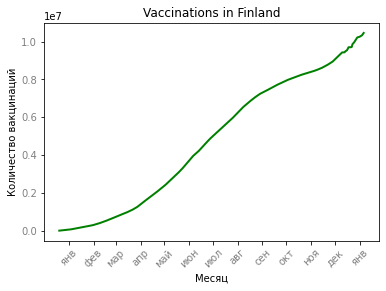

In [ ]:
country = input('Введите название страны: ')

x = list(data_table[data_table['Country'] == country].Date)
y = data_table[data_table['Country'] == country].Vaccinations

f1 = plt.figure(1)

plt.title(f'Vaccinations in {country}')
plt.xlabel('Месяц')
plt.ylabel('Количество вакцинаций')

# Выбираю отметки для дат - середины месяцев - 15ые числа
tick_values = [index for index,value in enumerate(x) if '-15' in value]
# Сопоставляю названия месяцев для этих дат
tick_names = []
for i in tick_values:
    tick_names.append(months[int(str(x[i])[5:7])-1]) 
tick_names_new = [elem[:3] for elem in tick_names]

plt.xticks(tick_values, tick_names_new, rotation =45, color='grey')
plt.yticks(color='grey')


plt.plot(x, y, linewidth=2, color='green')  
f1.show()

## Предикция конца вакцинаций по континентам

Введите название одного из континетов (South America, North America, Europe, Asia, Australia, Africa): Asia
День окончания вакцинации: 2022-07-29


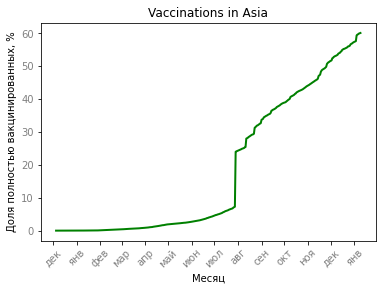

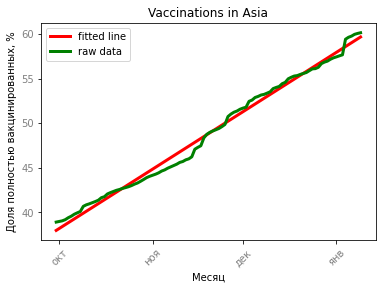

In [ ]:
country = input('Введите название одного из континетов (South America, North America, Europe, Asia, Australia, Africa): ')

x = list(data_table[data_table['Country'] == country].Date)
y = data_table[data_table['Country'] == country].Fully_Vaccinated_Ratio

f1 = plt.figure(1)

plt.title(f'Vaccinations in {country}')
plt.xlabel('Месяц')
plt.ylabel('Доля полностью вакцинированных, %')

# Выбираю отметки для дат - середины месяцев - 15ые числа
tick_values = [index for index,value in enumerate(x) if '-15' in value]
# Сопоставляю названия месяцев для этих дат
tick_names = []
for i in tick_values:
    tick_names.append(months[int(str(x[i])[5:7])-1]) 
tick_names_new = [elem[:3] for elem in tick_names]

plt.xticks(tick_values, tick_names_new, rotation =45, color='grey')
plt.yticks(color='grey')


plt.plot(x, y, linewidth=2, color='green')  
f1.show()

'''________________________________________________________________'''

# выбираю конечный линейный интервал графика

x = list(data_table[data_table['Country'] == country].Date)
x = x[int(len(x)*3/4):]

y = data_table[data_table['Country'] == country].Fully_Vaccinated_Ratio
y = y[int(len(y)*3/4):]

f2 = plt.figure(2)

plt.title(f'Vaccinations in {country}')
plt.xlabel('Месяц')
plt.ylabel('Доля полностью вакцинированных, %')


# Выбираю отметки для дат - середины месяцев - 15ые числа
tick_values = [index for index,value in enumerate(x) if '-15' in value]
# Сопоставляю названия месяцев для этих дат
tick_names = []
for i in tick_values:
    tick_names.append(months[int(str(x[i])[5:7])-1]) 
tick_names_new = [elem[:3] for elem in tick_names]

first_day = x[0]
x = range(len(x))

plt.xticks(tick_values, tick_names_new, rotation =45, color='grey')
plt.yticks(color='grey')

approximation = sps.linregress(x,y)
plt.plot(x, approximation.intercept + approximation.slope*x, 'r', linewidth=3, label='fitted line')

plt.plot(x, y, linewidth=3, color='green', label='raw data')  
plt.legend()
f2.show()

'''____________________________________________________________________________'''

# рассчитываю день окончания вакцинации
# y = k * x + b
k = approximation.slope
b = approximation.intercept

days_left = (100.0 - b)/k             # через сколько дней все провакцинируются
final_day = datetime.strptime(first_day, '%Y-%m-%d') + timedelta(days=days_left)
final_day = datetime.date(final_day)  # дата, когда все провакцинируются

print(f'День окончания вакцинации: {final_day}')